In [1]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [27]:
def compute_soft_argmin(t, cost, softmax_prescale=1.0):
    """ Computes soft argmin and creates a plot. """
    probability = -cost
    scaled_probability = softmax_prescale * probability
    softmax = np.exp(scaled_probability) / np.sum(np.exp(scaled_probability), axis=0)
    indices = np.arange(cost.shape[0])
    softmax_dot_indices = indices * softmax
    soft_argmin = sum(softmax_dot_indices)
    argmin = np.argmin(cost)
    
    # Plotting code
    fig = plt.figure(figsize=(10, 10))
    subplot_grid = gridspec.GridSpec(5, 1)

    axis1 = fig.add_subplot(subplot_grid[0])
#     axis1.set_title('Soft ArgMin', fontsize=18)
    axis1.set_ylabel('Cost', fontsize=18)
    axis1.plot(t, cost, 'b', linewidth=1.5)

    axis2 = fig.add_subplot(subplot_grid[1], sharex=axis1)
    axis2.set_ylabel('Probability', fontsize=18)
    axis2.plot(t, probability, 'b', linewidth=1.5)

    axis3 = fig.add_subplot(subplot_grid[2], sharex=axis1)
    axis3.set_ylabel('Softmax', fontsize=18)
    axis3.plot(t, softmax, 'b', linewidth=1.5)

    axis4 = fig.add_subplot(subplot_grid[3], sharex=axis1)
    axis4.set_ylabel('Indices', fontsize=18)
    axis4.plot(t, indices, 'b', linewidth=1.5)
    axis4.set_ylim([0, max_disparity+1])

    axis5 = fig.add_subplot(subplot_grid[4], sharex=axis1)
    axis5.set_ylabel('Softmax * Indices', fontsize=18)
    axis5.set_xlabel('Disparities [px]', fontsize=18)
    axis5.fill_between(x=t, y1=softmax_dot_indices, color='r')
    
    
    for axis in fig.axes:
        axis.set_xlim([0, max_disparity])
        axis.get_xaxis().tick_bottom()  
        axis.get_yaxis().tick_left()
    
    # Draw vertical line across all axes
    for axis in fig.axes:
        axis.axvline(x=soft_argmin,ymin=-0.5,ymax=1, linestyle='dotted',
                     color="k",linewidth=2, clip_on=(axis == fig.axes[-1]))
        axis.axvline(x=argmin,ymin=-0.5,ymax=1, linestyle='dashed',
                     color="k",linewidth=2, clip_on=(axis == fig.axes[-1]))
    
    import matplotlib
    axis5.legend(handles=[
            matplotlib.lines.Line2D([], [], color='k', label='True ArgMin', linestyle='dashed', linewidth=1.5),
            matplotlib.lines.Line2D([], [], color='k', label='Soft ArgMin', linestyle='dotted', linewidth=1.5)
        ], fontsize=18)

    # Tight subplot layout
    subplot_grid.tight_layout(fig, h_pad=0)

    return soft_argmin, argmin, fig

In [28]:
def fake_cost_curve(max_disparity=64, seed=0):
    """ Fakes a disparity cost curve by random walking. """
    np.random.seed(seed)
    
    t = np.arange(0, max_disparity + 1)
    cost = np.zeros(t.shape)

    for i in t[1:]:
        cost[i] = cost[i-1] + np.random.normal()
        
    return t, cost

## Potential figure for the paper
I basically just scrolled through seeds until I saw a curve that looks like a reasonable cost curve.

In [29]:
max_disparity=64

(16.211729177403008, 16)


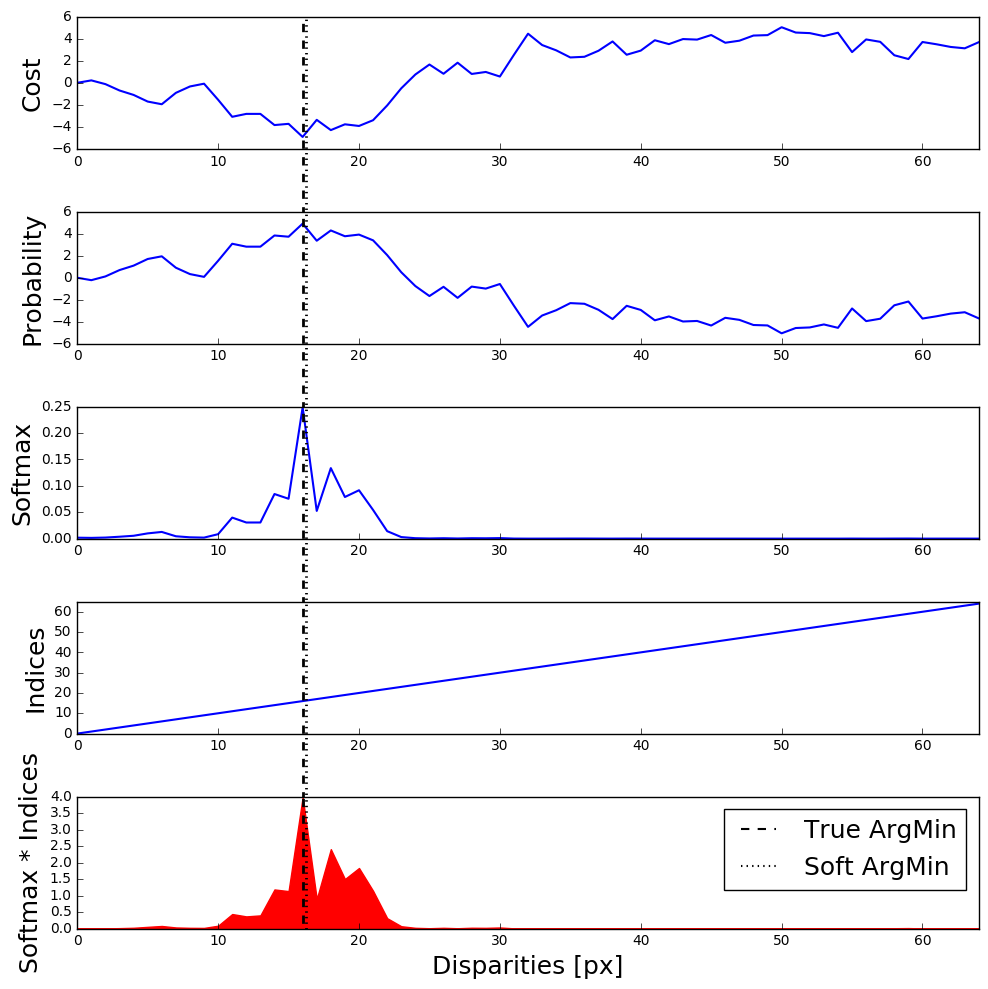

In [30]:
t, cost = fake_cost_curve(seed=19)
soft_argmin, argmin, fig = compute_soft_argmin(t, cost, softmax_prescale=1.0)
print(soft_argmin, argmin)
plt.draw()
fig.savefig("soft_argmin.pdf")

## Prescaling

The below plots show scenarios in which the cost curve is not a clear unimodal Gaussian, and the soft argmin operator diverges from the true argmin. And a proposal to scale the curve before applying softmax (a softmax prescale parameter), which steepens the softmax operation such that we converge towards the true argmin.

### One minimum and a large flat region
Take a look at the following cost curve, and how off the soft argmin is from the truth, due to the low cost in the low disparity region. Then, look at the improved result when we scale the probabilities before softmax by 3x:

(15.270964368449381, 22)


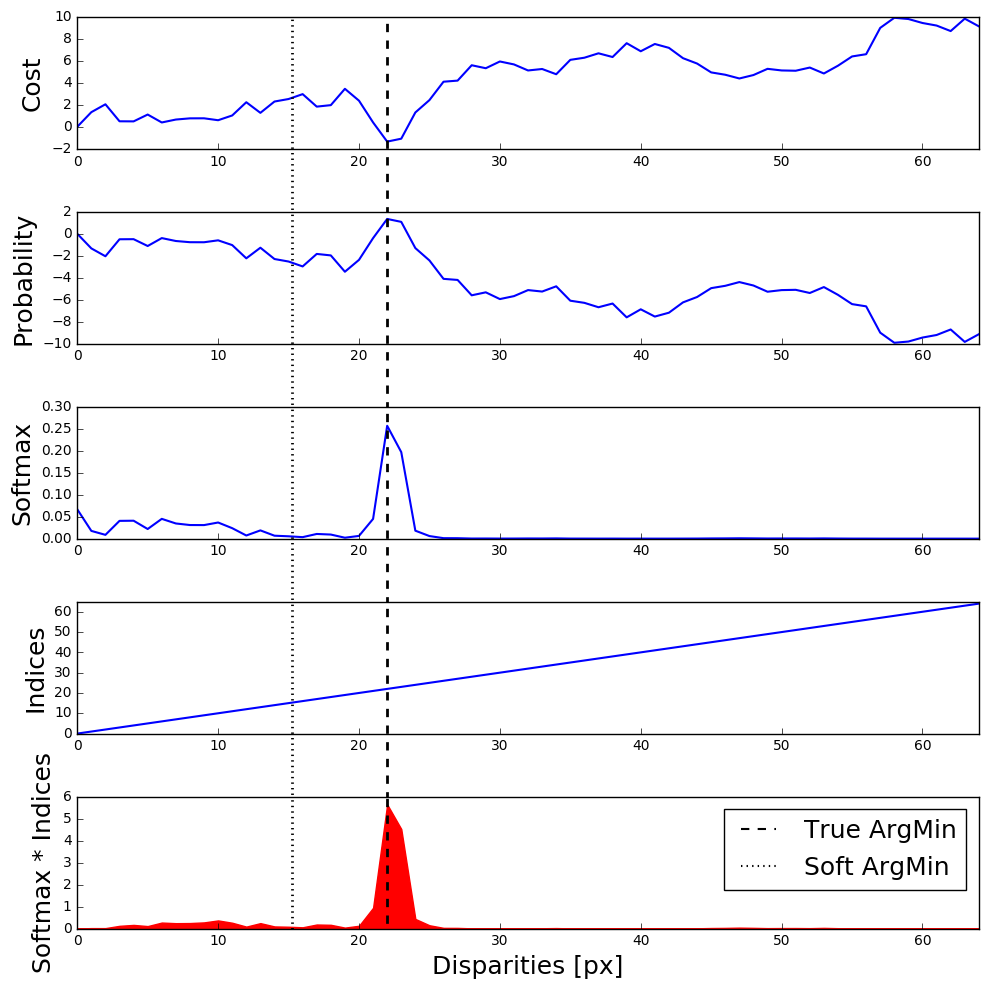

In [31]:
t, cost = fake_cost_curve(seed=10)
soft_argmin, argmin, fig = compute_soft_argmin(t, cost, softmax_prescale=1.0)
print(soft_argmin, argmin)
plt.draw()
fig.savefig("soft_argmin_multimodal.pdf")

(21.783489632688923, 22)


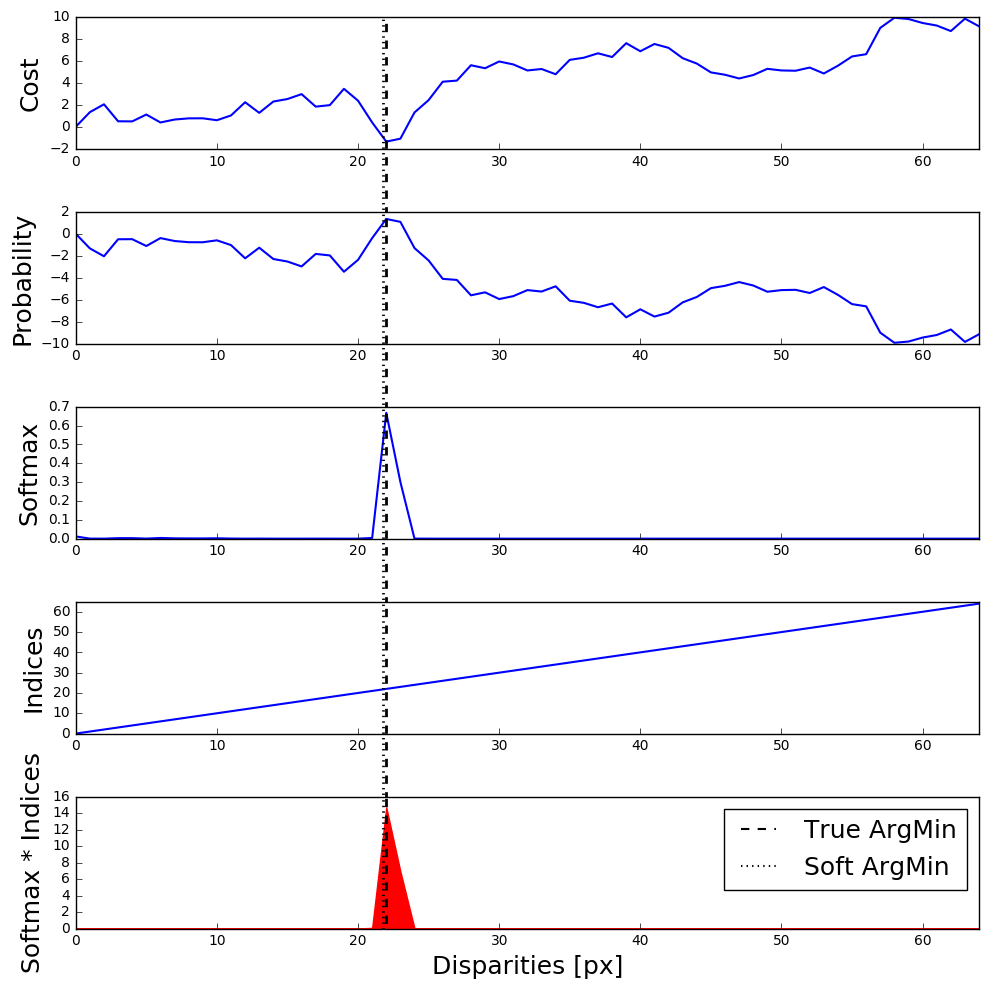

In [32]:
t, cost = fake_cost_curve(seed=10)
soft_argmin, argmin, fig = compute_soft_argmin(t, cost, softmax_prescale=3.0)
print(soft_argmin, argmin)
plt.draw()
fig.savefig("soft_argmin_multimodal_prescaling.pdf")

### Two near-equal modes
The below plots show a scenario in which the cost curve is very multimodal, nearly equal cost at ~37 and ~46 disparity. The following plots show that as you increase the softmax prescaling, the soft argmin goes from splitting the two peaks to converging towards the true argmin, while still preserving differentiability.

In [8]:
# Seed 7 happens to be multimodal
t, cost = fake_cost_curve(seed=7)

(43.730492268406685, 46)


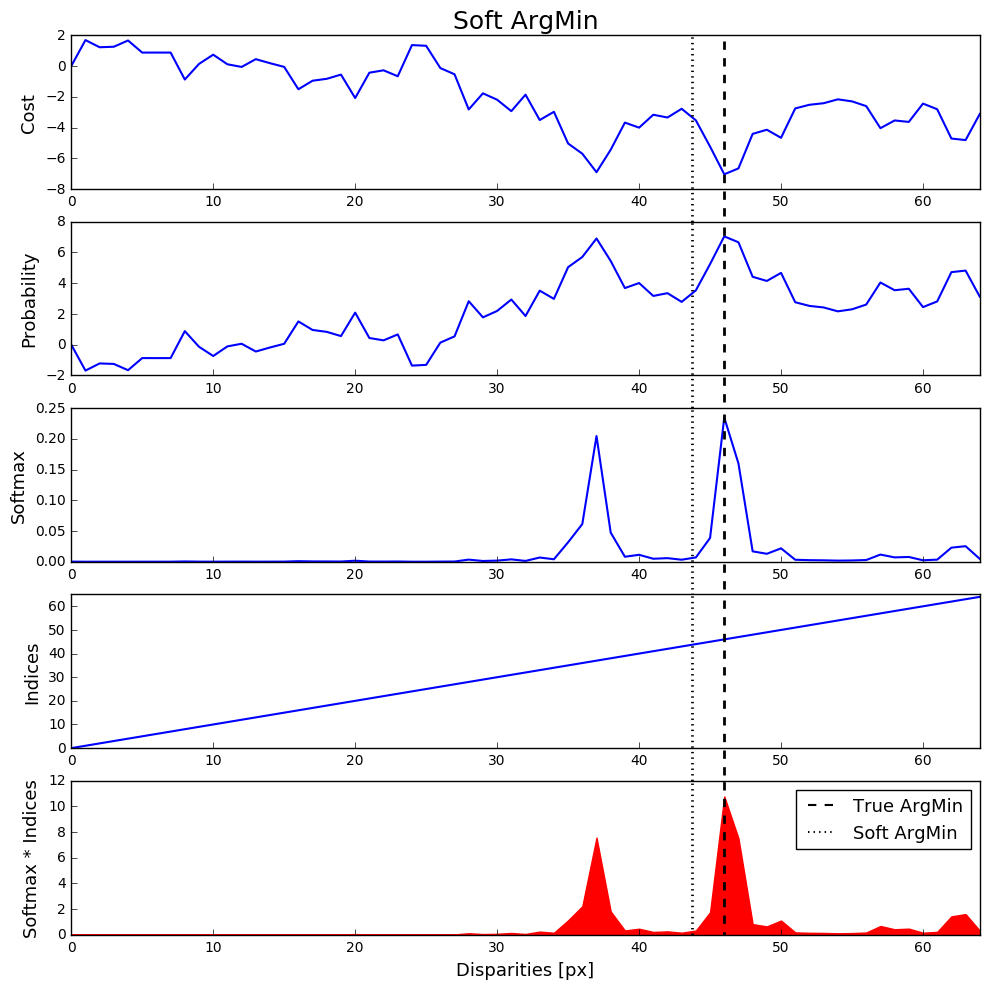

In [9]:
soft_argmin1, argmin1, fig1 = compute_soft_argmin(t, cost, softmax_prescale=1.0)
print(soft_argmin1, argmin1)
plt.draw()

(44.220707769251895, 46)


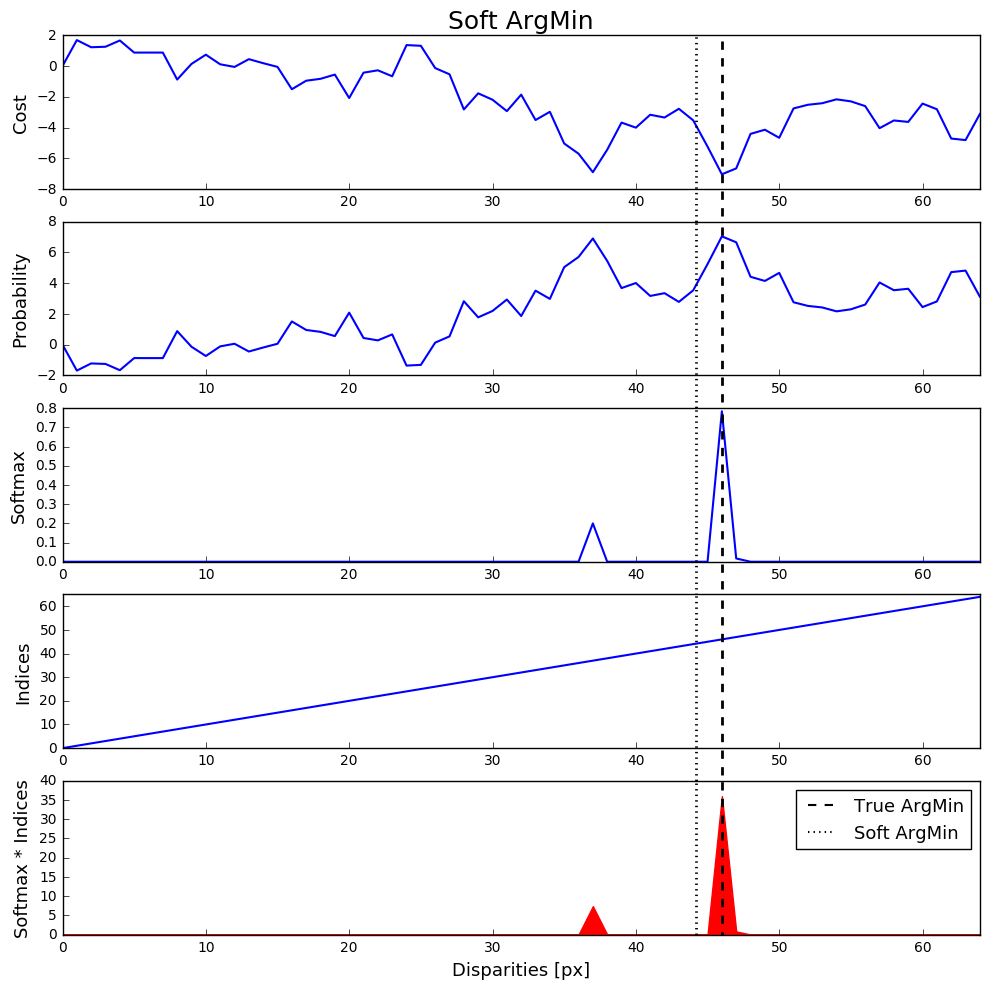

In [10]:
soft_argmin2, argmin2, fig2 = compute_soft_argmin(t, cost, softmax_prescale=10.0)
print(soft_argmin2, argmin2)
plt.draw()

(45.999989635605559, 46)


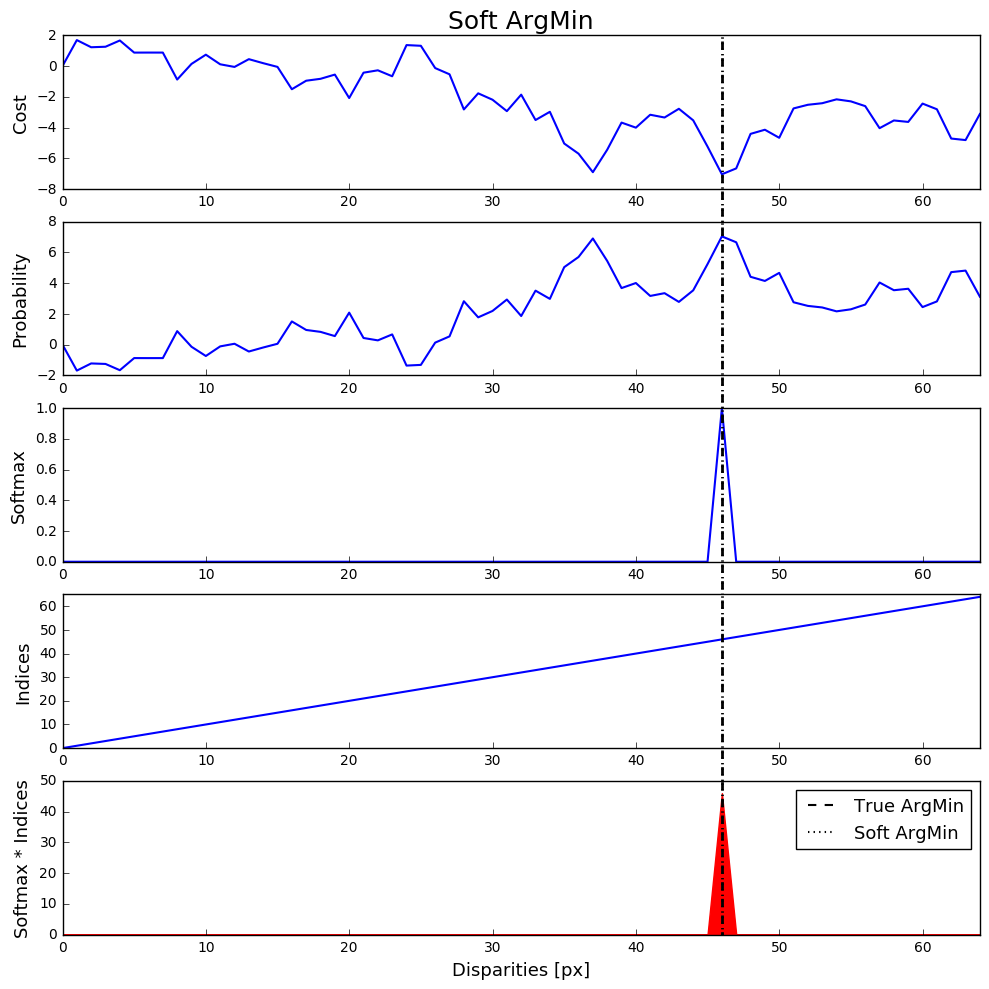

In [11]:
soft_argmin3, argmin3, fig3 = compute_soft_argmin(t, cost, softmax_prescale=100.0)
print(soft_argmin3, argmin3)
plt.draw()